# Market Basket Analysis


Market Basket Analysis is a technique used to find combinations of items that occur together frequently in transactions. This kind of analysis can provide essential insight into the buying patterns of consumers and can be leveraged to promote cross-selling of items through self placement and marketing campaigns.<br>
In this notebook, we try to find these associations in purchasing of different items and see if we can uncover some patterns to improve the business.

In [1]:
# importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import csv

%matplotlib inline

### Loading and preparing the dataset

We start by importing the dataset.<br>
The dataset is a text file that contains a line for every transaction and the items for every transaction seperated by a comma.

In [2]:
item_set = set()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=',')
    for line in reader:
        item_set.update(line)

transaction_list = []
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=',')
    for line in reader:
        row_dict = {item:0 for item in item_set}
        row_dict.update({item:1 for item in line})
        transaction_list.append(row_dict)

grocery = pd.DataFrame(transaction_list)

grocery.head()

,UHT-milk,flower soil/fertilizer,chocolate marshmallow,liquor,frozen fish,honey,bottled water,cling film/bags,salt,ham,...,skin care,shopping bags,sausage,frozen meals,whisky,house keeping products,sugar,fish,syrup,whipped/sour cream
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This format of transaction data is ideal to feed into the apriori algorithm. We will proceed with some descriptives and EDA

In [3]:
grocery.shape

(9835, 169)

We have 9835 transactions in the dataset with 169 individual items.<br>
Next we explore these items and their frequency of occurance.

### Visualizations

Lets get a visual of the frequently occuring items

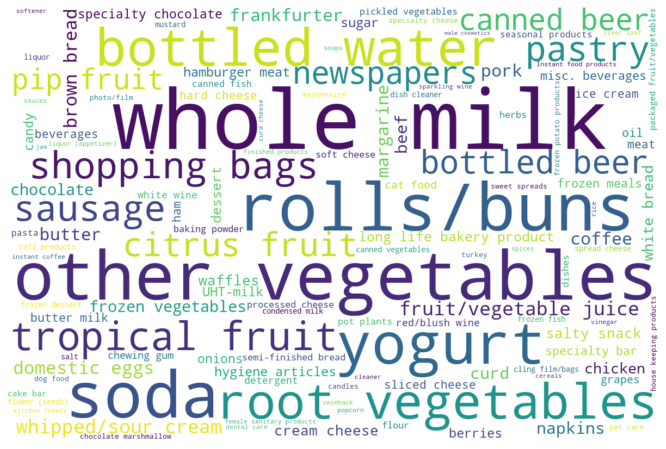

In [4]:
from wordcloud import WordCloud

item_frequency = grocery.sum(axis=0).to_dict()
wc = WordCloud(background_color='white', height=800, width=1200, max_words=121)
wc.generate_from_frequencies(item_frequency)
plt.rcParams['figure.figsize']=(25, 8)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

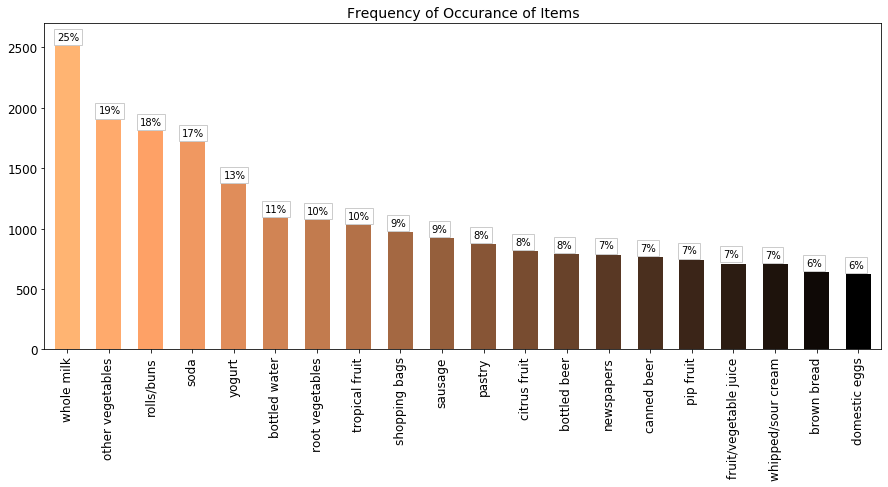

In [5]:
fig, ax = plt.subplots(figsize=(15,6))
counts = grocery.sum(axis=0).sort_values(ascending=False)
color = plt.cm.copper(np.linspace(0.9, 0, 20))
counts.head(20).plot(kind='bar', rot=90, fontsize=12, width=0.6, align='center', color=color, ax=ax)
for i, item in enumerate(counts.head(20).index):
    ax.annotate('%d%%'%(counts[item]*100/len(grocery)), (i-0.25, counts[item]+50), fontsize=10,
                bbox=dict(boxstyle="square", fc="white", ec="black", lw=1, alpha=0.2))
plt.ylim(0, 2700)
_ = plt.title('Frequency of Occurance of Items', fontsize=14)

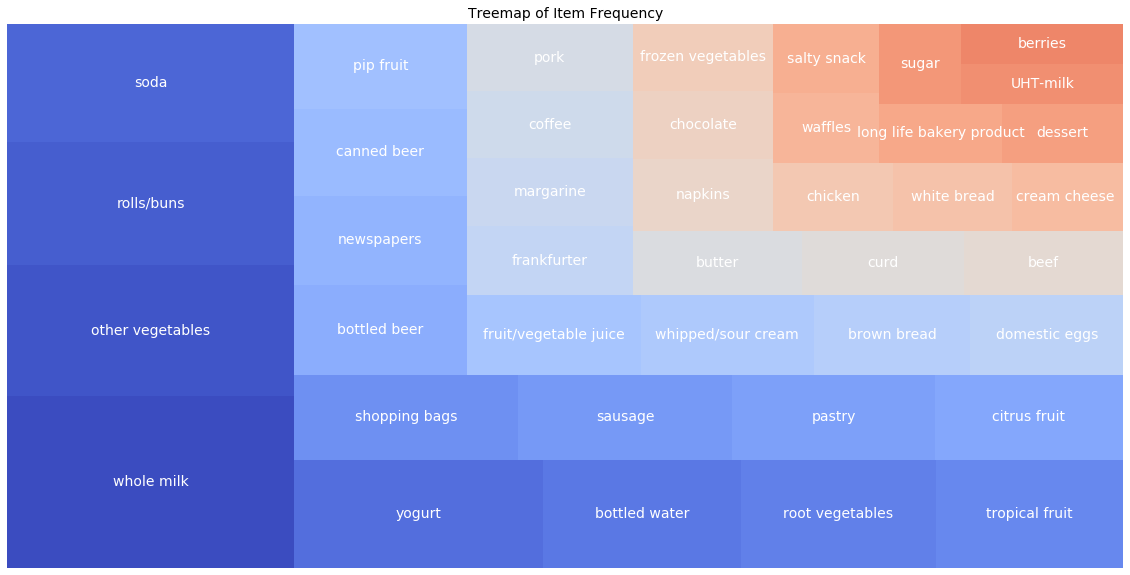

In [6]:
import squarify
plt.rcParams['figure.figsize']=(20, 10)
color = plt.cm.coolwarm(np.linspace(0, 1, 50))
squarify.plot(sizes=counts.head(40).values, label=counts.head(50).index, color=color, 
              text_kwargs={'fontsize':14, 'color':'white', })
plt.axis('off')
_ = plt.title('Treemap of Item Frequency', fontsize=14)

We see that the items whole milk, other vegetables and rolls/buns are the most frequently occuring items.<br>
Next we try to find the association between the purchases of these items.

### Frequent Item sets and Association rules

Market Basket Analysis typically involved finding the most frequently occuring combinations of items (item sets) in a dataset of transactions. 
The analysis consists of two parts:
1. Finding the frenquently occuring itemsets that occur above a pre-defined frequency threshold (support).
2. Deriving association rules between these itemsets using metrics of association such as cofidence, lift and conviction.

Frequent items are found using the apriori algorithm that counts the occurence of itemsets starting from 1 item per set and increasing the items per set (candidate generation). Itemsets that are above the support threshold are returned in a dataframe with their corresponding support levels.

Association rules can be interpreted as rules that predict the occurence of an itemset (Y) if itemset (X) has occured in a transaction. These express the strength to which the consequent (secondary) itemset is dependent on the (primary) antecedent itemset. 
Association Rules are obtained from these frequent items by using metrics that define the strength and direction of association of these itemsets. 
We use confidence, lift and conviction as our measure.
- Confidence: Ratio of the occurence of two itemsets together to the occurence of the consiquent alone<br>
Basically measure how often the rule is true.
- Lift: Ratio of the observed support of two itemsets together to the support expected if the two itemsets were independent.<br>
Measures how often X & Y occur together compared to what we would expect if their occurences were independent of each other.
- Conviction: Ratio of the occurence of X without y if X and Y were independent vs if they are dependent.
Measures the degree of dependence of occurence of Y (consequent) on the occurence of X (antecedent)


The first thing to do is to find the appropriate support level for shortlisting the frequent itemsets.<br>
We loop through a few support levels and plot the number of rules generated to get an idea of the support threshold to use.

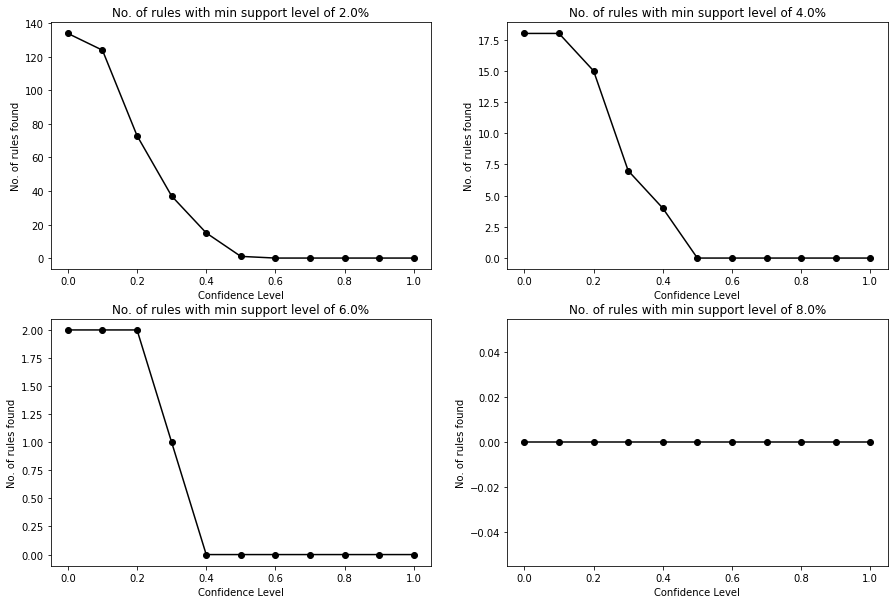

In [7]:
from mlxtend.frequent_patterns import apriori, association_rules

min_support = np.linspace(0.02, 0.08, 4)
confidence_levels = np.linspace(0, 1, 11)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
ax = axs.flat
for i, s in enumerate(min_support):
    frequent_itemsets = apriori(grocery, min_support=s, use_colnames=True)
    rule_count = []
    for c in confidence_levels:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=c)
        rule_count.append(len(rules))
    
    ax[i].plot(confidence_levels, rule_count, color='black', marker='o')
    ax[i].set(title=f'No. of rules with min support level of {100*s}%', xlabel='Confidence Level', 
              ylabel='No. of rules found')

We can see that the amount of rules found, drops sharply as we increase our support level. This suggests that the range of items is quite large and repition is less.<br>
At any of the support thresholds, we cannot observe any rules past a confidence level > 0.5.<br>
We consider a support level of 3% to shortlist the frequent itemsets. We use 'lift' as our metric of choice as it better identifies the association found between itemsets by providing both the direction (positive or negative) and the strength of association found. A lift score of 1 indicates independence.

In [11]:
frequent_itemsets = apriori(grocery, min_support=0.03, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

We sort these by lift to see which rules stick out.

In [14]:
# Viewing the rules sorted by 'support'
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(other vegetables),(root vegetables),0.193493,0.108998,0.047382,0.244877,2.246605,0.026291,1.179941
7,(root vegetables),(other vegetables),0.108998,0.193493,0.047382,0.434701,2.246605,0.026291,1.426693
28,(sausage),(rolls/buns),0.093950,0.183935,0.030605,0.325758,1.771048,0.013324,1.210344
29,(rolls/buns),(sausage),0.183935,0.093950,0.030605,0.166390,1.771048,0.013324,1.086899
9,(tropical fruit),(other vegetables),0.104931,0.193493,0.035892,0.342054,1.767790,0.015589,1.225796
8,(other vegetables),(tropical fruit),0.193493,0.104931,0.035892,0.185497,1.767790,0.015589,1.098913
26,(whipped/sour cream),(whole milk),0.071683,0.255516,0.032232,0.449645,1.759754,0.013916,1.352735
27,(whole milk),(whipped/sour cream),0.255516,0.071683,0.032232,0.126144,1.759754,0.013916,1.062323
14,(whole milk),(root vegetables),0.255516,0.108998,0.048907,0.191405,1.756031,0.021056,1.101913
15,(root vegetables),(whole milk),0.108998,0.255516,0.048907,0.448694,1.756031,0.021056,1.350401


It is important to take all the metrics into consideration before acting on the associations that are extracted from the data.<br>
The results obtained suggest a strong buying correlation between (top 5):
 - root Vegetables -> other vegetables
 - sausages -> rolls/buns 
 - tropical fruit -> other vegetables
 - whipped/sour cream -> whole milk
 - root vegetables -> whole milk